In [1]:
import tensorflow as tf

%matplotlib inline
from pylab import *
import matplotlib
matplotlib.rcParams['figure.figsize']=[22, 20]
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from data_loaders import loc_det_train_loader, make_valid_localization_data

/Users/florianmuellerklein/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/florianmuellerklein/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Localization with Classification

In this example we will simply add a second output to our localization network, responsible for predicting the class of the digit in the image. This strategy works in cases like this, where we only have one object and one class per image. The next step after creating this type of network would be create a more flexible version by creating an output similar to that of [YOLO](https://pjreddie.com/media/files/papers/yolo.pdf).

### Load the Sklearn digits dataset

Make the localization dataset using the provided utility. The `make_valid_localization_data` will set up our validation dataset by placing the digit on some random location in an image. We want our validation dataset to be fixed so that we can fairly compare the results between each epoch. Our training datset will be generated on the fly during training. This way we can have almost an unlimited number of training examples. No digits will be shared between the training and validation datasets.

In [2]:
digits = load_digits()['data']
labels = load_digits()['target']

lblr = LabelBinarizer()

labels = lblr.fit_transform(labels)

tr_digits, tst_digits, tr_labels, tst_labels = train_test_split(digits, labels)
tst_digits, tst_coords = make_valid_localization_data(tst_digits, noise=0.1)

print(tst_digits.shape, tst_coords.shape, tst_labels.shape)

(450, 32, 32, 1) (450, 4) (450, 10)


### Create a function to plot the digits

We want to be able to see whether or not we've achieved our goal so we'll create a function to plot the image an some given bounding box. Additionally, we'll add a flag to pull from the true validation data so that we can compare the results after training. This function will also take the label for each image and display that as the title.

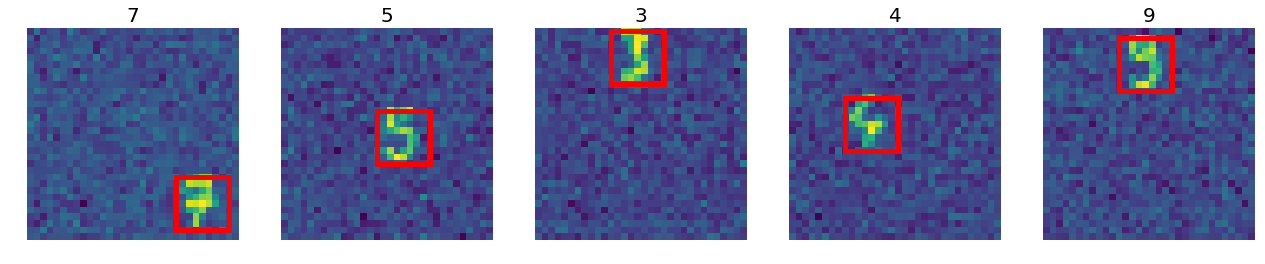

In [3]:
def plot_images(img_array, coord_array, labels, incl_true=False):
    fig, axes = plt.subplots(1, 5)
    for i, row in enumerate(axes):
        axes[i].axis('off')
        # get the coordinates in matplotlib rect format
        x = int(coord_array[i][0] * 32)
        y = int(coord_array[i][2] * 32)
        width = int(coord_array[i][1] * 32) - x
        height = int(coord_array[i][3] * 32) - y
        # add rectangle to the image
        axes[i].add_patch(patches.Rectangle((x, y), 
                                             width, height, fill=False, linewidth=5, color='r'))
        axes[i].set_title(str(np.argmax(labels[i])), fontsize=20)
        
        # true values are a global variable in this notebook so we'll just pull it from there
        if incl_true:
            # get the coordinates of the true value
            t_x = int(tst_coords[i][0] * 32)
            t_y = int(tst_coords[i][2] * 32)
            t_width = int(tst_coords[i][1] * 32) - x
            t_height = int(tst_coords[i][3] * 32) - y
            # add the true bounding box
            axes[i].add_patch(patches.Rectangle((t_x, t_y), 
                                                 t_width, t_height, fill=False, linewidth=5, linestyle=':', color='y'))
        axes[i].imshow(tst_digits[i].squeeze())
    plt.show()

plot_images(tst_digits, tst_coords, tst_labels)

## Set up our TF graph

At this point you should be quite comfortable setting up TensorFlow graphs. Therefore the rest of the network and loss function creation will be left as an exercise ;D. 

Remember, that we are doing a multi-output style neural network here. So we will need two outputs and two corresponding loss functions for those outputs. We still only need one optimizer and we can create a total loss by taking the weighted sum of the two loss functions. it might be necessary to weight one loss function greater than the other in order to get the network to learn both coordinates and classes.

In [4]:
with tf.name_scope('input_placeholder'):
    X = tf.placeholder(tf.float32, shape=(None, 32, 32, 1), name='X')
    
with tf.name_scope('targets_coord_placeholder'):
    y_coords = tf.placeholder(tf.float32, shape=(None, 4), name='y')
    
with tf.name_scope('targets_class_placeholder'):
    y_class = tf.placeholder(tf.float32, shape=(None, 10), name='y')

In [5]:
import neural_net_layers as nn

with tf.name_scope('cnn'):
    conv_1 = nn.conv_layer(X, in_dims=1, n_kernels=16, kernel_size=5, name='conv_a', activation=tf.nn.relu)
    pool_1 = nn.max_pool(conv_1, pool_size=2, name='pool_a')
    
    conv_2 = nn.conv_layer(pool_1, in_dims=16, n_kernels=32, kernel_size=5, name='conv_b', activation=tf.nn.relu)
    pool_2 = nn.max_pool(conv_2, pool_size=2, name='pool_b')
    
    conv_3 = nn.conv_layer(pool_2, in_dims=32, n_kernels=64, kernel_size=5, name='conv_c', activation=tf.nn.relu)
    pool_3 = nn.max_pool(conv_3, pool_size=2, name='pool_c')
    
    # it's important to watch your tensor shapes when using CNNs because you have to flatten
    # the representation for a dense layer, or you may downsample to a 0x0 feature map
    flat = tf.reshape(pool_3, [-1, 4*4*64])
    
    # regression head for the localization
    dense_a = nn.dense_layer(flat, 32, name='dense_layer_coord', activation=tf.nn.relu)
    y_pred_coords = nn.dense_layer(dense_a, 4, name='coord_output') 
    
    # classification head for the class labels
    dense_b = nn.dense_layer(flat, 32, name='dense_layer_class', activation=tf.nn.relu)
    y_pred_class = nn.dense_layer(dense_b, 10, name='class_output') 

In [6]:
with tf.name_scope('loss'):
    # coordinate loss
    error = y_pred_coords - y_coords
    bb_loss = tf.reduce_mean(tf.square(error), name='mse')
    # class loss
    class_loss = 0.1 * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_class, logits=y_pred_class))
    loss = bb_loss + class_loss
    
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.01, name='adam_optimizer').minimize(loss)
    
with tf.name_scope('class_prediction'):
    class_predictions = y_pred_class
    
with tf.name_scope('coord_prediction'):
    coord_predictions = y_pred_coords

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Train the Network

We'll provide the training code to give you some hints.

In [7]:
EPOCHS = 150

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
        loc_loader = loc_det_train_loader(tr_digits, tr_labels, noise=0.1)
        for X_b, y_b_coord, y_b_class in loc_loader:
            _, train_loss = sess.run([train_step, loss], feed_dict={X: X_b, 
                                                                    y_coords: y_b_coord, 
                                                                    y_class: y_b_class})
            
        if e % 3 == 0:
            print('loss:', train_loss)
            
    saver = tf.train.Saver()
    saver.save(sess, './saved_model/cnn_mnist_loc.ckpt')

loss: 0.28037345
loss: 0.23939136
loss: 0.25038904
loss: 0.22678345
loss: 0.23218346
loss: 0.23342612
loss: 0.23534569
loss: 0.23138991
loss: 0.22770579
loss: 0.23150039
loss: 0.23861112
loss: 0.23276417
loss: 0.22373618
loss: 0.23251037
loss: 0.20821199
loss: 0.23103857
loss: 0.23498407
loss: 0.22534683
loss: 0.20403975
loss: 0.23054045
loss: 0.18696976
loss: 0.17209588
loss: 0.26410374
loss: 0.24238394
loss: 0.18190293
loss: 0.1491103
loss: 0.19716483
loss: 0.12121939
loss: 0.2384453
loss: 0.15215288
loss: 0.27252138
loss: 0.17805861
loss: 0.11226719
loss: 0.29208153
loss: 0.14652047
loss: 0.07503371
loss: 0.072101384
loss: 0.11963381
loss: 0.15454268
loss: 0.10654613
loss: 0.1433348
loss: 0.1667177
loss: 0.14195392
loss: 0.11999744
loss: 0.15188543
loss: 0.08172075
loss: 0.18295214
loss: 0.106111765
loss: 0.081054404
loss: 0.03174026


## Make predictions on the validation data and plot the results

In [10]:
with tf.Session() as sess:
    saver.restore(sess, './saved_model/cnn_mnist_loc.ckpt')
    coords_preds, class_preds, test_bbox_loss = sess.run([y_pred_coords, 
                                                          y_pred_class,
                                                          bb_loss], 
                                                          feed_dict={X: tst_digits,
                                                                     y_coords: tst_coords})
    

def accuracy(pred_probs, true_labels):
    corrects = np.equal(np.argmax(pred_probs, 1), np.argmax(true_labels, 1))
    return np.mean(corrects)

print(test_bbox_loss)
print(accuracy(class_preds, tst_labels))

INFO:tensorflow:Restoring parameters from ./saved_model/cnn_mnist_loc.ckpt
0.0018122765
0.7288888888888889


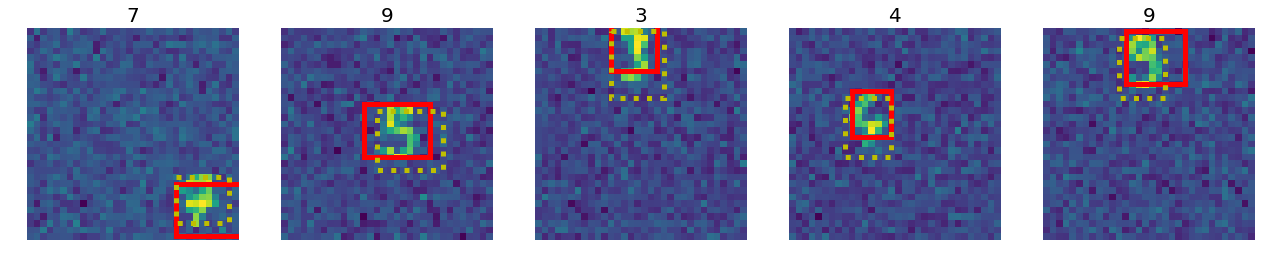

In [9]:
plot_images(tst_digits, coords_preds, class_preds, incl_true=True)